<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/DNC/Desafio%207%20-%20Clusteriza%C3%A7%C3%A3o/Desafio7_Clusterizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Carregamento de bibliotecas**

In [ ]:
#Carregando Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer

#**Análise exploratória e Pré Processamento dos dados**

In [ ]:
#Carregando dados
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [ ]:
#Analisando dados inconsistentes: Temos tanto Quantidades quanto Preços negativos nos dados

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
#Analisando dados: uma quantidade significativa de CustomerID são nulos. Algumas colunas não estão no formato correto.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Corrigindo Tipos

In [ ]:
#Corrigindo tipos

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(str)

## Dados Nulos

In [ ]:
#Dados Nulos
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df.loc[df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [ ]:
#Removendo os dados nulos de CustomerID.
df.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
#Optei por não remover os dados faltantes de descrição, pois não atrapalharão o processo.
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


## Dados Duplicados

In [ ]:
#Dados Duplicados
df.duplicated().sum()

5268

In [ ]:
df.drop_duplicates(inplace=True)

##Dados inconsistentes

In [ ]:
#Dados incosistentes

df.drop(df[df['Quantity'] < 0].index, inplace=True)
df.drop(df[df['UnitPrice'] < 0].index, inplace=True)


##Outliers

<Axes: >

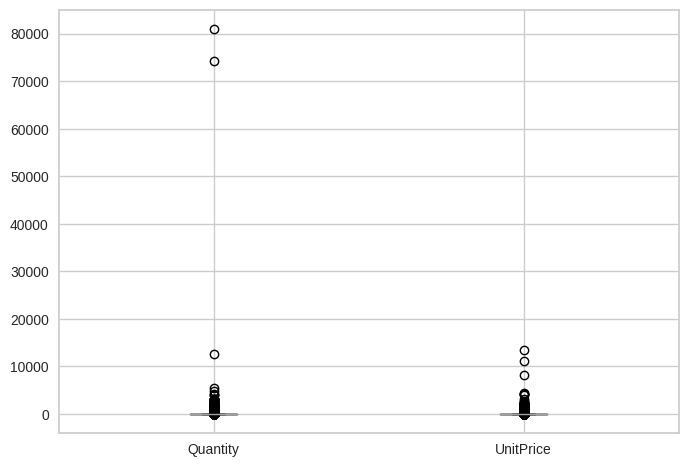

In [ ]:
#Outliers
df.boxplot()

In [ ]:
#Eliminando valores muito extremos

df.drop(df[df['Quantity'] > 5000].index, inplace=True)
df.drop(df[df['UnitPrice'] > 5000].index, inplace=True)

## Adicionando colunas novas para a análise RFM

In [ ]:
#Adicionando coluna de valor total gasto pelo consumidor (Monetary Value)
df['Total'] = df['Quantity'] * df['UnitPrice']

In [ ]:
#Adicionando coluna de número de vezes compradas pelo consumidor (Frequency)
df['Frequencia'] = df.groupby('CustomerID')['InvoiceNo'].transform('count')

In [ ]:
#Adicionando coluna de última vez comprado pelo consumidor (Recency)
df['Recencia'] = (pd.to_datetime('2011-12-31') - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

<Axes: >

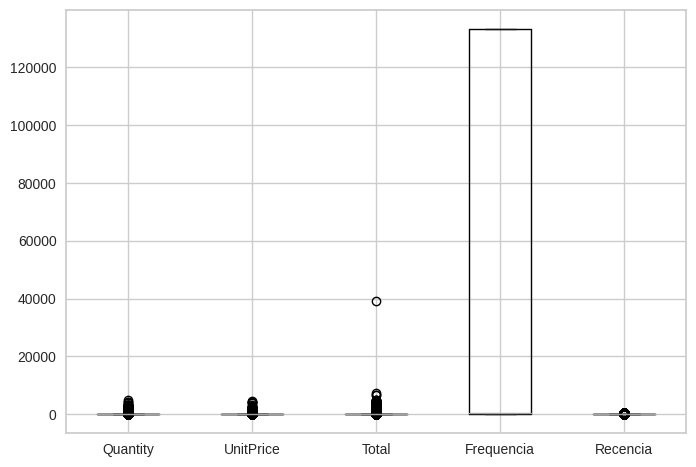

In [ ]:
df.boxplot()

<Axes: >

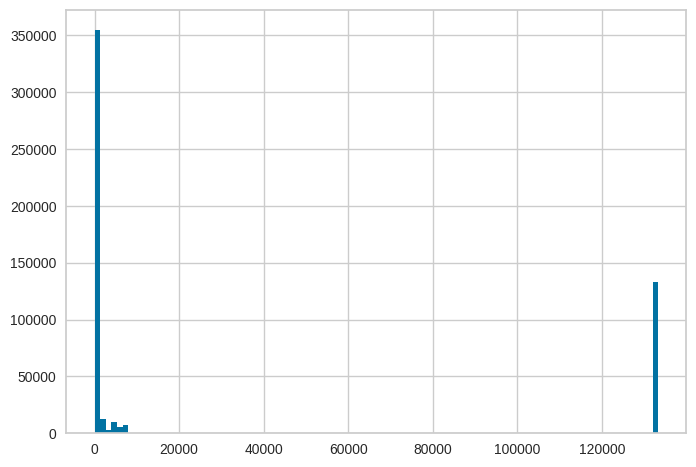

In [ ]:
df.Frequencia.hist(bins=100)

In [ ]:
#A coluna Total parece exibir um número extremo que pode desbalancear a normalização, por isso optei por retirá-lo. A Frequência também possui um outlier que pode atrapalhar nossa avaliação, por isso o removi.
df.drop(df[df['Total'] > 5500].index, inplace=True)
df.drop(df[df['Frequencia'] > 20000].index, inplace=True)

##Seleção de variáveis

In [ ]:
#Para seguir com o nosso modelo, vou seguir com as novas colunas criadas, elas serão a base para chegarmos ao entendimento dos clusters e insights.
df_selected = df[['Recencia', 'Frequencia', 'Total']].copy()

## Normalização dos dados

In [ ]:
#normalizando com MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_selected)

In [ ]:
df_scaled = pd.DataFrame(df_scaled, columns=df_selected.columns)

#**Clusterização**

##Buscando número de grupos

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

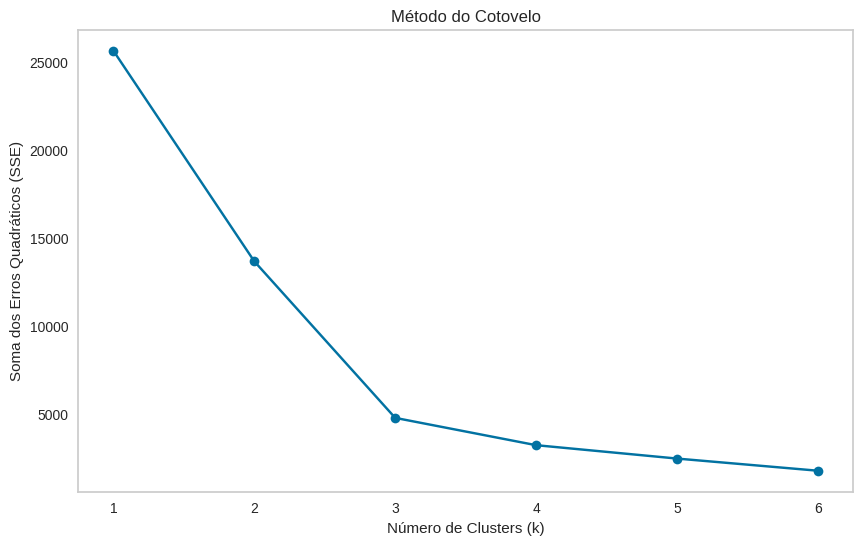

In [ ]:
#Visualização do método elbow

sse = []

for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 7), sse, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Soma dos Erros Quadráticos (SSE)')
plt.xticks(range(1, 7))
plt.grid()
plt.show()

In [ ]:
cluster_metrics = calinski_harabasz_score, davies_bouldin_score
cluster_metrics_results = []

for k in range (2,7):
  model = KMeans(n_clusters = k, random_state = 42)
  labels = model.fit_predict(df_scaled)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_scaled, labels)
  cluster_metrics_results.append(cluster_results_dict)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [ ]:
#As métricas apontam para 2 a 3 clusters como um resultado satisfatório. Especialmente o método elbow parece apontar para 3, por isso seguirei com essa opção.

df_results = pd.DataFrame(cluster_metrics_results).set_index('k')
styled_df = df_results.style.background_gradient()

styled_df

,inertia,calinski_harabasz_score,davies_bouldin_score
k,,,
2,13673.283676,343341.940979,0.373495
3,4786.990252,854862.179720,0.419313
4,3237.197291,905427.625253,0.510614
5,2477.715605,917305.458237,0.539293
6,1787.532988,1047512.327745,0.523200


## Escolha do modelo

Pela clareza na quantidade de grupos que busco utilizando os testes anteriores, optei por utilizar o método KMeans. Além disso, esse modelo apresenta definições mais claras entre os grupos, facilitando o entendimento e a interpretação dos dados e direcionando uma ações no negócio.

In [ ]:
#K-means

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_selected)
df['Cluster'] = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#**Analisando dados obtidos**

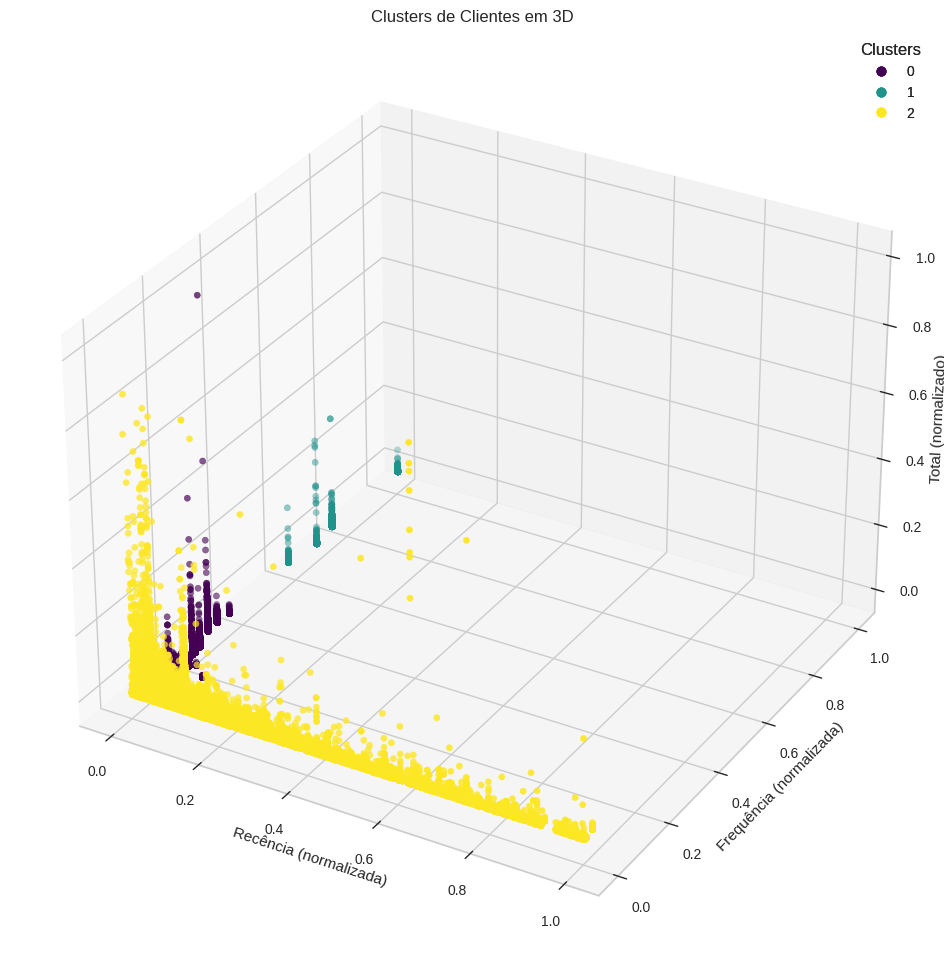

In [ ]:
#Gráficos de avaliação - Gráfico 3D

df_3d = np.array(df_scaled)

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_3d[:, 0],
                     df_3d[:, 1],
                     df_3d[:, 2],
                     c=df['Cluster'],
                     cmap='viridis',
                     marker='o')

ax.set_title('Clusters de Clientes em 3D')
ax.set_xlabel('Recência (normalizada)')
ax.set_ylabel('Frequência (normalizada)')
ax.set_zlabel('Total (normalizado)')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

Os grupos parecem ser separados principalmente pela frequência de compra dos consumidores, havendo um grupo que possui uma frequência bem alta de compras enquanto, outro médio e um terceiro baixo.

In [ ]:
#Gráficos de avaliação - Gráfico de barras

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
centroids_df = pd.DataFrame(np.array(centroids), columns=df_scaled.columns)

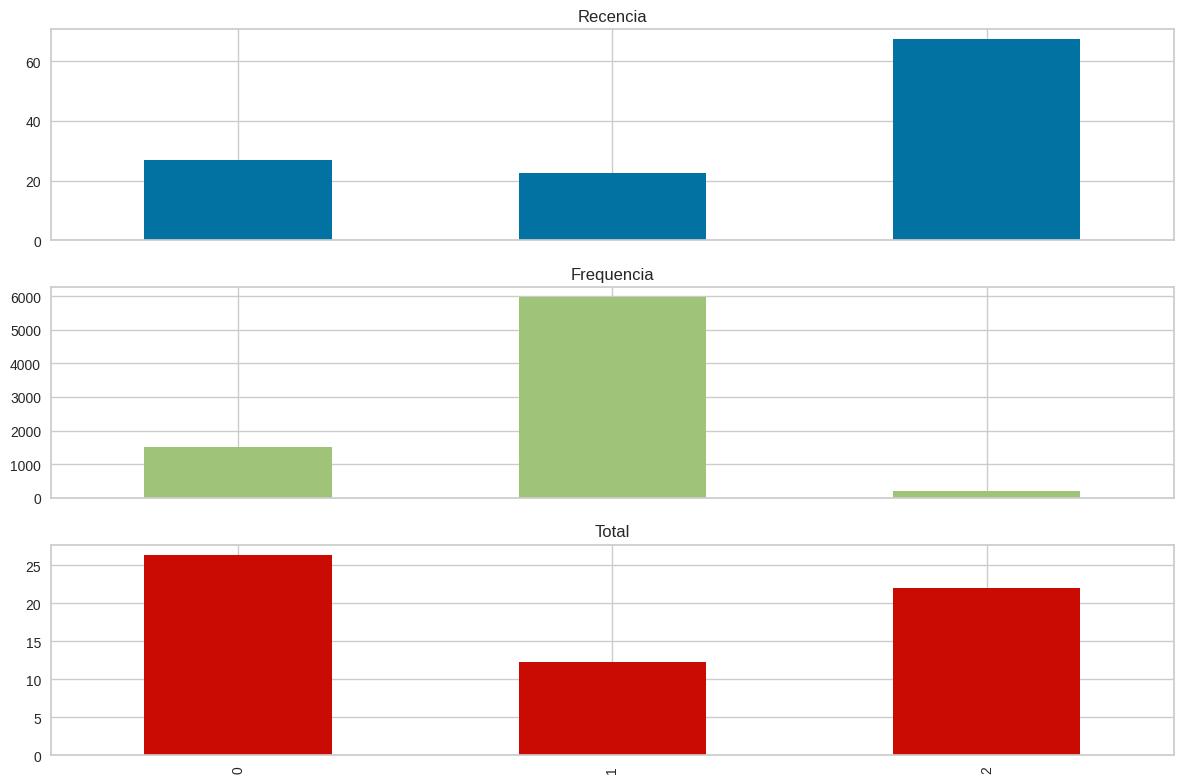

In [ ]:
axes = centroids_df.plot.bar(subplots=True, figsize=(12, 8), legend=False)

plt.tight_layout()
plt.show()

Olhando para o gráfico de barras conseguimos separar os grupos mais adequadamente.

**Grupo 0** - Alto gasto total nos produtos, com uma frequência intermediária e uma recência também intermediária.

**Grupo 1** - Alta frequência de compra com uma recência também intermediária, porém seu valor gasto é o menor dos 3 grupos.

**Grupo 2** - Alta recência, valor gasto de médio para alto e frequência bem baixa.

#**Interpretações dos dados obtidos**

###**Recência baixa é boa para o negócio:**

Valores mais baixos indicam que o cliente fez uma compra recentemente, o que é bom para o negócio, pois indica que o cliente está engajado.

###**Frequência alta é boa para o negócio:**

Valores mais altos são desejáveis, pois indicam que o cliente compra com frequência, o que é positivo para o negócio.

###**Valor Monetário alto é bom para o negócio:**

Quanto mais alto for esse valor, melhor para o negócio, já que o cliente está gerando mais receita.

#**Perfil de compra dos usuários e possíveis ações**

##**1. Grupo 0 - Compradores Premium 💰**

**Características:** Alto gasto total, frequência intermediária e recência intermediária.

**Interpretação:** Este grupo é formado por clientes que gastam bastante em seus produtos, mas compram em uma frequência moderada e não fazem suas compras tão recentemente. Esses clientes são valiosos devido ao seu gasto elevado, e vale a pena investir em estratégias para mantê-los engajados, como ofertas especiais ou programas de fidelidade para aumentar a frequência de compras.

##**2. Grupo 1 - Clientes Frequentes de Baixo Valor 🔄**

**Características:** Alta frequência de compra, recência intermediária, mas menor valor gasto.

**Interpretação:** Este grupo representa clientes que compram com frequência, mas gastam pouco em cada compra. São clientes importantes para a recorrência, mas pode ser interessante oferecer incentivos para aumentar o valor de seus pedidos, como descontos em compras maiores ou cross-selling de produtos.

##**3. Grupo 2 - Compradores Ocasionais de Valor Médio 🌱**

**Características:** Alta recência, gasto médio para alto, e baixa frequência.

**Interpretação:** Esses clientes fizeram uma compra recente e gastaram uma quantia significativa, mas não compram com frequência. Para esse grupo, vale a pena trabalhar em estratégias para aumentar a frequência de compras, como campanhas de remarketing ou ofertas personalizadas para incentivá-los a voltar mais rápido.